Feature: Search Chaining
========================

To perform a model-fit, we typically compose one model and fit it to our data using one non-linear search.

Search chaining fits many different models to a dataset using a chained sequence of non-linear searches. Initial
fits are performed using simplified model parameterizations and faster non-linear fitting techniques. The results of
these simplified fits can then be used to initialize fits using a higher dimensionality model with more detailed
non-linear search.

To fit highly complex models our aim is therefore to granularize the fitting procedure into a series of **bite-sized**
searches which are faster and more reliable than fitting the more complex model straight away.

Our ability to construct chained non-linear searches that perform model fitting more accurately and efficiently relies
on our **domain specific knowledge** of the model fitting task. For example, we may know that our dataset contains
multiple features that can be accurately fitted separately before performing a joint fit, or that certain parameter
share minimal covariance such that certain parameters can be fixed before fitting both with a more complex model
parameterization.

We may also know tricks that can speed up the fitting of the initial model, for example reducing the size of the data
or changing the likelihood evaluations in a way that makes them quicker (likely at the expense of the overall
quality of the fit itself). By using chained searches these speed-ups can be relaxed towards the end of the
model-fitting sequence when we want the most precise, most accurate model that best fits the dataset available.

In this example we demonstrate search chaining using the example data where there are two `Gaussians` that are visibly
split. Instead of fitting them simultaneously using a single non-linear search consisting of N=6 parameters, we break
this model-fit into a chained of three searches where:

 1) The first model fits just the left `Gaussian` where N=3.
 2) The first model fits just the right `Gaussian` where again N=3.
 3) The final model is fitted with both `Gaussians` where N=6. Crucially, the results of the first two searches
 are used to initialize the search and tell it the highest likelihood regions of parameter space.

By initially fitting parameter spaces of reduced complexity we can achieve a more efficient and reliable model-fitting
procedure.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import model as m
import analysis as a

import matplotlib.pyplot as plt
import numpy as np
from os import path

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Data__

First, lets load data of two 1D Gaussians, by loading it from a .json file in the directory 
`autofit_workspace/dataset/gaussian_x1_with_feature`.

This 1D data includes two `Gaussians` that are split from one another.

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x2_split")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Now lets plot the data, including its error bars. 

Two separate `Gaussians` are clearly visible.

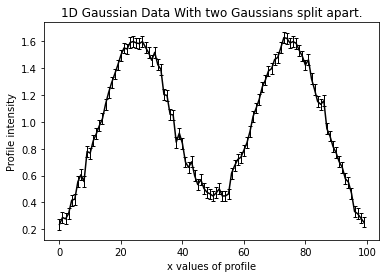

In [3]:
xvalues = range(data.shape[0])

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian Data With two Gaussians split apart.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Analysis__

Our Analysis class is described in `analysis.py` and is the same used in the `overview/complex` example. 

It fits the data as the sum of as many `Gaussian`'s as are in the model.

To better fit the left gaussian, we remove all data points in the right-half of the data. Note that for more 
computationally demanding model-fitting problems this would give a significant speed-up in log likelihood function.

In [4]:
analysis = a.Analysis(data=data[0:50], noise_map=noise_map[0:50])

__Model__

We are now going to fit the left `Gaussian` in this split dataset. 

In [5]:
model = af.Collection(gaussian_left=m.Gaussian)

__Search[1]__

We will now fit the data with the `left_gaussian` using a single non-linear search. 

Given the simplicity of the model, we can use a low number of live points to achieve a fast model-fit.

In [6]:
dynesty = af.DynestyStatic(
    name=("search[1]__left_gaussian"),
    path_prefix=path.join("features", "search_chaining"),
    nlive=30,
    iterations_per_update=500,
)

search_1_result = dynesty.fit(model=model, analysis=analysis)

INFO:root:search[1]__left_gaussian already completed, skipping non-linear search.


By plotting the result we can see we have fitted the left `Gaussian` reasonably well.

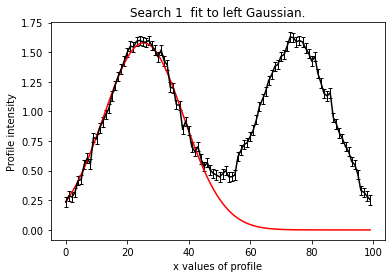

In [7]:
instance = search_1_result.max_log_likelihood_instance

model_data = instance.gaussian_left.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.title("Search 1  fit to left Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Search[2]__

We now repeat the above process for the right `Gaussian`.

We could remove the data on the left like we did the `Gaussian` above. However, we are instead going to fit the full 
dataset.

In [8]:
analysis = a.Analysis(data=data, noise_map=noise_map)

Because the left Gaussian is now again in the data, we need to fit it. We can do this, without increasing the 
dimensionality of our parameter space to N=6, by using the maximum log likelihood model of the `gaussian_left` in
search[1].

For search chaining, **PyAutoFit** has many convenient methods for passing the results of a search to a subsequence 
search. Below, we achieve this by passing the result of the search above as an `instance.

In [9]:
model = af.Collection(
    gaussian_left=search_1_result.instance.gaussian_left, gaussian_right=m.Gaussian
)

We now run our second Dynesty search to fit the right `Gaussian`.

Given the simplicity of the model, we can again use a low number of live points to achieve a fast model-fit.

In [10]:
dynesty = af.DynestyStatic(
    name=("search[2]__right_gaussian"),
    path_prefix=path.join("features", "search_chaining"),
    nlive=30,
    iterations_per_update=500,
)

search_2_result = dynesty.fit(model=model, analysis=analysis)

INFO:root:search[2]__right_gaussian already completed, skipping non-linear search.


By plotting the result we can see we have fitted the right `Gaussian` reasonably well and that the model includes the
`left_gaussian` from the first search.

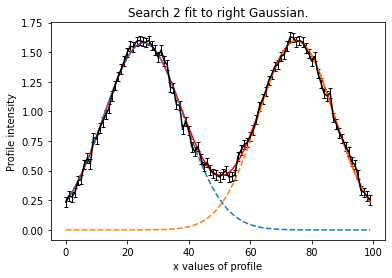

In [11]:
instance = search_2_result.max_log_likelihood_instance

gaussian_left = instance.gaussian_left.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
gaussian_right = instance.gaussian_right.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

model_data = gaussian_left + gaussian_right

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), gaussian_left, "--")
plt.plot(range(data.shape[0]), gaussian_right, "--")
plt.title("Search 2 fit to right Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Search[3]__

We now fit both `Gaussians`'s simultaneously, using the results of the previous two searches to initialize where 
the non-linear searches parameter space.

To pass the result in this way we use the command `result.model`, which in contrast to `result.instance` above passes
the parameters not as the maximum log likelihood values but as `GaussianPrior`'s that are fitted for by the
non-linear search. We discuss below how this `GaussianPrior` is passed.

In [12]:
model = af.Collection(
    gaussian_left=search_1_result.model.gaussian_left,
    gaussian_right=search_2_result.model.gaussian_right,
)

dynesty = af.DynestyStatic(
    name=("search[3]__both_gaussians"),
    path_prefix=path.join("features", "search_chaining"),
    nlive=100,
    iterations_per_update=500,
)

search_3_result = dynesty.fit(model=model, analysis=analysis)

INFO:root:search[3]__both_gaussians already completed, skipping non-linear search.


By plotting the result we can now see we have fitted both `Gaussian`'s accurately.

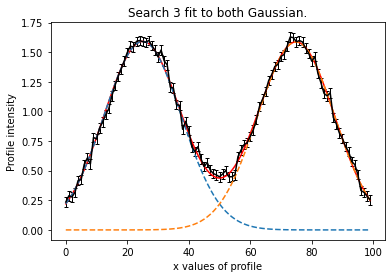

In [13]:
instance = search_3_result.max_log_likelihood_instance

gaussian_left = instance.gaussian_left.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
gaussian_right = instance.gaussian_right.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

model_data = gaussian_left + gaussian_right

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(range(data.shape[0]), model_data, color="r")
plt.plot(range(data.shape[0]), gaussian_left, "--")
plt.plot(range(data.shape[0]), gaussian_right, "--")
plt.title("Search 3 fit to both Gaussian.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Prior Passing__

Now search 3 is complete, you should checkout its `model.info` file. The parameters do not use the default priors of 
the `Gaussian` model component. Instead, they use GaussianPrior`s where:

 - The mean values are the median PDF results of every parameter inferred by the fits performed in searches 1 and 2.
 - They sigma values are the errors computed by these searches, or they are values higher than these errors.

The sigma values uses the errors of searches 1 and 2 for an obvious reason, this is a reasonable estimate of where in
parameter space the model-fit can be expected to provide a good fit to the data. However, we may want to specify 
even larger sigma values on certain parameters, if for example we anticipate that our earlier searches may under 
estimate the errors.

The `width_modifier` term in the `Gaussian` section of the `config/priors/gaussian.ini` is used instead of the errors 
of a search, when the errors estimated are smaller  than the `width_modifier` value. This ensure that the sigma 
values used in later searches do not assume extremely small values if earlier searches risk under estimating the errors.

Thus, search 3 used the results of searches 1 and 2 to inform it where to search non-linear parameter space! 

The `PriorPasser` customizes how priors are passed from a search as follows:

 - sigma: The sigma value of the errors passed to set the sigma values in the previous search are estimated at.
 - use_widths: If False, the "width_modifier" values in the json_prior configs are not used to override a passed
 error value.
 - use_errors: If False, errors are not passed from search 1 to set up the priors and only the `width_modifier`
  entries in the configs are used.  

There are two ways a value is specified using the priors/width file:

 1) Absolute: In this case, the error assumed on the parameter is the value given in the config file. 
  For example, if for the width on `centre` the width modifier reads "Absolute" with a value 20.0, this means if the 
  error on the parameter `centre` was less than 20.0 in the previous search, the sigma of its `GaussianPrior` in 
  the next search will be 20.0.

 2) Relative: In this case, the error assumed on the parameter is the % of the value of the estimate value given in 
 the config file. For example, if the intensity estimated in the previous search was 2.0, and the relative error in 
 the config file reads "Relative" with a value 0.5, then the sigma of the `GaussianPrior` 
  will be 50% of this value, i.e. sigma = 0.5 * 2.0 = 1.0.

We use absolute and relative values for different parameters, depending on their properties. For example, using the 
relative value of a parameter like the `centre` makes no sense as the profile could be centred at 0.0, making 
the relative error tiny and poorly defined.

However, there are parameters where using an absolute value does not make sense. Intensity is a good example of this. 
The intensity of an image depends on its units and S/N. There is no single absolute value that one can use to 
generically chain the intensity of any two proflies. Thus, it makes more sense to chain them using the relative value 
from a previous search.

We can customize how priors are passed from the results of a search and `NonLinearSearch` by inputting to the search 
a `PriorPasser` object:

In [14]:
search = af.DynestyStatic(
    prior_passer=af.PriorPasser(sigma=2.0, use_widths=False, use_errors=True)
)

The `PriorPasser` allows us to customize at what sigma the error values the model results are computed at to compute
the passed sigma values and customizes whether the widths in the config file, these computed errors, or both, 
are used to set the sigma values of the passed priors.

The default values of the `PriorPasser` are found in the config file of every non-linear search, in the [prior_passer]
section. All non-linear searches by default use a sigma value of 3.0, use_width=True and use_errors=True.

__EXAMPLE__

Lets go through an example using a real parameter. Lets say in search 1 we fit a `Gaussian` and we estimate that 
its intensity is equal to 4.0 +- 2.0 where the error value of 2.0 was computed at 3.0 sigma confidence. To pass this 
as a prior to search 2, we would write:

    gaussian.intensity = search_1_result.model.gaussian.intensity

The prior on the `Gaussian` `intensity` in search 2 would thus be a `GaussianPrior`, with mean=4.0 and 
sigma=2.0. If we had used a sigma value of 1.0 to compute the error, which reduced the estimate from 4.0 +- 2.0 to 
4.0 +- 1.0, the sigma of the `GaussianPrior` would instead be 1.0. 

If the error on the intensity in search 1 had been really small, lets say, 0.01, we would instead use the value of the 
intensity width in the priors config file to set sigma instead. In this case, the prior config file specifies 
that we use an "Relative" value of 0.5 to chain this prior. Thus, the GaussianPrior in search 2 would have a mean=4.0 
and sigma=2.0.

And with that, we`re done. Chaining searches is a bit of an art form, but for certain problems can be extremely 
powerful.